In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from pingouin import bayesfactor_ttest
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import TTestIndPower
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

## Women vs. Men

In [2]:
df = pd.read_pickle("../../data/adhd-beliefs-pt/adhd-beliefs-pt-liwc-proportional.pkl")
mask_women = (df['sex']=="Feminino")
mask_others = ~mask_women
features = df.columns[-64:].tolist()

## Necessary functions

In [3]:
def univariate_liwc(df, features, mask_g1, mask_g2, alpha=0.05):
    """
    For each LIWC feature:
      - Welch’s t-test
      - JZS Bayes factor
      - Cohen’s d
    Returns a DataFrame with p-values, BF10, d, FDR‐corrected p’s, etc.
    """
    rows = []
    for feat in features:
        g1 = df.loc[mask_g1, feat].dropna()
        g2 = df.loc[mask_g2, feat].dropna()
        t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
        n1, n2 = len(g1), len(g2)
        bf10 = bayesfactor_ttest(t_stat, n1, n2, paired=False)
        s1, s2 = g1.std(ddof=1), g2.std(ddof=1)
        s_pool = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
        d = (g1.mean() - g2.mean())/s_pool
        rows.append({
            'feature': feat,
            'mean_g1': g1.mean(),
            'sd_g1': s1,
            'mean_g2': g2.mean(),
            'sd_g2': s2,
            't_stat': t_stat,
            'p_val': p_val,
            'bf10': bf10,
            'cohen_d': d
        })
    df_res = pd.DataFrame(rows)
    _, p_corr, _, _ = multipletests(df_res['p_val'], method='fdr_bh')
    df_res['p_fdr'] = p_corr
    df_res['signif'] = df_res['p_fdr'] < alpha
    df_res['abs_cohen_d'] = df_res['cohen_d'].abs()
    return df_res.sort_values('abs_cohen_d', ascending=False)

In [4]:
def pca_group_diff(df, features, mask_g1, mask_g2, n_pc=5, alpha=0.05):
    """
    Standardize LIWC features, run PCA, perform Welch’s t-test on each PC
    Returns a DataFrame of PC, explained_variance, t_stat, p_val, p_fdr.
    """
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n_pc)
    pcs = pca.fit_transform(Xs)
    rows = []
    for i in range(n_pc):
        comp = pcs[:, i]
        t, p = stats.ttest_ind(comp[mask_g1], comp[mask_g2], equal_var=False)
        rows.append({
            'PC': f'PC{i+1}',
            'expl_var': pca.explained_variance_ratio_[i],
            't_stat':   t,
            'p_val':    p
        })
    df_pc = pd.DataFrame(rows)
    _, p_corr, _, _ = multipletests(df_pc['p_val'], method='fdr_bh')
    df_pc['p_fdr'] = p_corr
    return df_pc

In [5]:
def top_pc1_loadings(df, features, n=10):
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    pca = PCA(n_components=1)
    pca.fit(Xs)
    load = pd.Series(pca.components_[0], index=features)
    df_load = load.abs().sort_values(ascending=False).head(n).to_frame('abs_loading')
    df_load['loading'] = load.loc[df_load.index]
    return df_load

In [6]:
def l1_logistic_top(df, features, mask_g1, n=10):
    X = df[features].fillna(0).values
    Xs = StandardScaler().fit_transform(X)
    y = mask_g1.astype(int)
    clf = LogisticRegressionCV(
        Cs=10, cv=5, penalty='l1', solver='saga',
        scoring='roc_auc', max_iter=7500, random_state=42
    )
    clf.fit(Xs, y)
    coef = pd.Series(clf.coef_[0], index=features)
    df_coef = coef.abs().sort_values(ascending=False).head(n).to_frame('abs_coef')
    df_coef['coef'] = coef.loc[df_coef.index]
    return df_coef

In [7]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    sx, sy = np.std(x, ddof=1), np.std(y, ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / s_pooled

In [8]:
def abs_cohen_d(x, y):
    return abs(cohen_d(x, y))

In [9]:
def bootstrap_ci(x, y, statfunc, n_boot=1000, ci=95):
    boot_stats = []
    for _ in range(n_boot):
        bx = resample(x, replace=True)
        by = resample(y, replace=True)
        boot_stats.append(statfunc(bx, by))
    lower = np.percentile(boot_stats, (100-ci)/2)
    upper = np.percentile(boot_stats, 100-(100-ci)/2)
    return lower, upper

In [10]:
def a_priori_power(effect_size=0.6, alpha=0.05, power=0.8):
    analysis = TTestIndPower()
    return analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')

## Analysis

In [11]:
# 1) Univariate LIWC
uni = univariate_liwc(df, features, mask_women, mask_others)
print("\nLIWC dimensions |d| > 0.3:")
print(uni[uni['abs_cohen_d']>0.3].to_markdown(index=False, floatfmt=".3f"))


LIWC dimensions |d| > 0.3:
| feature   |   mean_g1 |   sd_g1 |   mean_g2 |   sd_g2 |   t_stat |   p_val |   bf10 |   cohen_d |   p_fdr | signif   |   abs_cohen_d |
|:----------|----------:|--------:|----------:|--------:|---------:|--------:|-------:|----------:|--------:|:---------|--------------:|
| ppron     |     0.118 |   0.048 |     0.096 |   0.046 |    2.938 |   0.004 |  8.689 |     0.475 |   0.250 | False    |         0.475 |
| i         |     0.043 |   0.027 |     0.033 |   0.029 |    2.341 |   0.021 |  2.122 |     0.389 |   0.551 | False    |         0.389 |
| shehe     |     0.062 |   0.033 |     0.051 |   0.031 |    2.254 |   0.026 |  1.774 |     0.362 |   0.551 | False    |         0.362 |
| certain   |     0.011 |   0.012 |     0.016 |   0.018 |   -1.726 |   0.088 |  0.685 |    -0.311 |   0.819 | False    |         0.311 |
| pronoun   |     0.171 |   0.056 |     0.155 |   0.053 |    1.877 |   0.063 |  0.876 |     0.302 |   0.819 | False    |         0.302 |


In [12]:
# 2) Bootstrap CIs for features with |d| > 0.3
top_feats = uni[uni['abs_cohen_d'] > 0.3]['feature']
ci_list = []
for feat in top_feats:
    x = df.loc[mask_women, feat].dropna().values
    y = df.loc[mask_others, feat].dropna().values
    d_obs = cohen_d(x, y)
    lo, hi = bootstrap_ci(x, y, cohen_d, n_boot=2000, ci=95)
    ci_list.append({'feature': feat, 'd': d_obs, 'ci_lower': lo, 'ci_upper': hi})
ci_df = pd.DataFrame(ci_list)
print("\nBootstrap 95% CIs for Cohen's d (|d| > 0.3):")
print(ci_df.to_markdown(index=False, floatfmt=".3f"))


Bootstrap 95% CIs for Cohen's d (|d| > 0.3):
| feature   |      d |   ci_lower |   ci_upper |
|:----------|-------:|-----------:|-----------:|
| ppron     |  0.475 |      0.174 |      0.831 |
| i         |  0.389 |      0.037 |      0.759 |
| shehe     |  0.362 |      0.065 |      0.678 |
| certain   | -0.311 |     -0.620 |      0.012 |
| pronoun   |  0.302 |     -0.008 |      0.648 |


In [13]:
# 3) A priori power
req_n = a_priori_power(effect_size=0.6)
print(f"\nRequired N per group for d=0.6, α=0.05, 80% power: {req_n:.1f}")


Required N per group for d=0.6, α=0.05, 80% power: 44.6


In [14]:
# 4) PCA group differences
pc_res = pca_group_diff(df, features, mask_women, mask_others)
print("\nPCA group differences:")
print(pc_res.to_markdown(index=False, floatfmt=".3f"))


PCA group differences:
| PC   |   expl_var |   t_stat |   p_val |   p_fdr |
|:-----|-----------:|---------:|--------:|--------:|
| PC1  |      0.149 |    1.351 |   0.179 |   0.381 |
| PC2  |      0.081 |    1.031 |   0.305 |   0.381 |
| PC3  |      0.069 |   -0.100 |   0.921 |   0.921 |
| PC4  |      0.062 |    1.152 |   0.252 |   0.381 |
| PC5  |      0.053 |    1.117 |   0.266 |   0.381 |


In [15]:
# 5) PCA group differences
pc1_ld = top_pc1_loadings(df, features, n=15)
print("\nTop PC1 loadings:")
print(pc1_ld[['loading']].to_markdown(floatfmt=".3f"))


Top PC1 loadings:
|         |   loading |
|:--------|----------:|
| ipron   |     0.275 |
| funct   |     0.274 |
| pronoun |     0.274 |
| nonfl   |     0.241 |
| shehe   |     0.238 |
| article |     0.237 |
| social  |     0.230 |
| you     |     0.224 |
| ppron   |     0.221 |
| cogmech |     0.220 |
| space   |     0.206 |
| preps   |     0.173 |
| incl    |     0.168 |
| discrep |     0.162 |
| excl    |     0.162 |


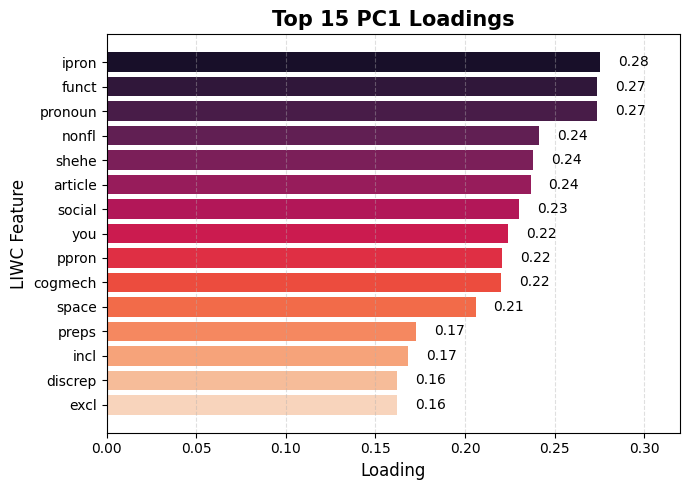

In [16]:
# Use seaborn's rocket palette for colors
palette = sns.color_palette("rocket", len(pc1_ld))

plt.figure(figsize=(7, 5))
bars = plt.barh(pc1_ld.index, pc1_ld['loading'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 PC1 Loadings", fontsize=15, weight='bold')
plt.xlabel("Loading", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with loading values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.01 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(0, 0.32)

plt.tight_layout()
plt.show()

In [17]:
# 6) L1 logistic features
lasso = l1_logistic_top(df, features, mask_women, n=15)
print("\nTop L1 logistic features:")
print(lasso[['coef']].to_markdown(floatfmt=".3f"))


Top L1 logistic features:
|         |   coef |
|:--------|-------:|
| funct   |  0.000 |
| pronoun |  0.000 |
| ppron   |  0.000 |
| i       |  0.000 |
| we      |  0.000 |
| you     |  0.000 |
| shehe   |  0.000 |
| they    |  0.000 |
| ipron   |  0.000 |
| article |  0.000 |
| verb    |  0.000 |
| auxverb |  0.000 |
| past    |  0.000 |
| present |  0.000 |
| future  |  0.000 |


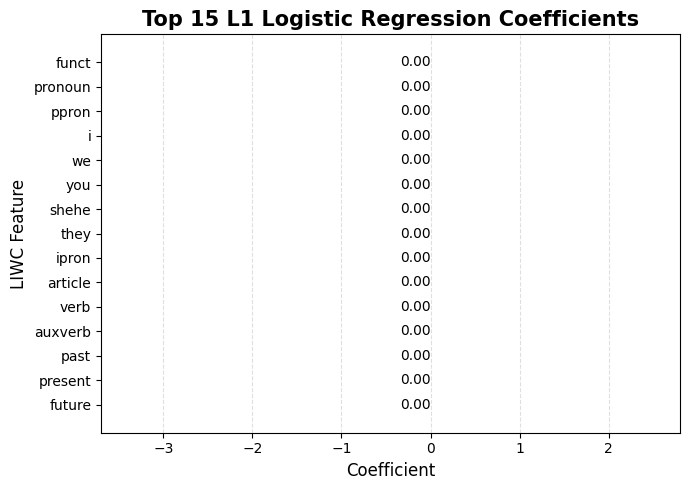

In [18]:
# Plotting top L1 logistic coefficients with seaborn's rocket palette
plt.figure(figsize=(7, 5))
palette = sns.color_palette("rocket", len(lasso))
bars = plt.barh(lasso.index, lasso['coef'], color=palette)
plt.gca().invert_yaxis()
plt.title("Top 15 L1 Logistic Regression Coefficients", fontsize=15, weight='bold')
plt.xlabel("Coefficient", fontsize=12)
plt.ylabel("LIWC Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with coefficient values
for bar in bars:
    width = bar.get_width()
    plt.gca().text(
        width + 0.05 * np.sign(width), 
        bar.get_y() + bar.get_height()/2, 
        f"{width:.2f}", 
        va='center', ha='left' if width > 0 else 'right', fontsize=10
    )
    
plt.xlim(-3.7, 2.8)

plt.tight_layout()
plt.show()

In [19]:
# 7) Repeated CV for AUC stability
X = df[features].fillna(0).values
y = mask_women.astype(int).values
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
clf = LogisticRegression(penalty='l1', solver='saga', max_iter=5000)
auc_scores = cross_val_score(clf, X, y, cv=rkf, scoring='roc_auc')
print(f"\nRepeated CV AUC: mean={auc_scores.mean():.3f}, SD={auc_scores.std():.3f}")


Repeated CV AUC: mean=0.500, SD=0.000
